#### <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:150%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > TABLE OF CONTENTS<br><div>  
* [IMPORTS](#1)
* [INTRODUCTION](#2)
    * [CONFIGURATION](#2.1)
    * [CONFIGURATION PARAMETERS](#2.2)    
    * [DATASET COLUMNS](#2.3)
* [PREPROCESSING](#3)
* [ADVERSARIAL CV](#4)
* [EDA AND VISUALS](#5) 
* [DATA TRANSFORMS](#6)
* [MODEL TRAINING](#7)      
* [PLANNED WAY FORWARD](#8)     

<a id="1"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > IMPORTS<br> <div> 

In [1]:
%%time 

# Installing select libraries:-
from gc import collect;
from warnings import filterwarnings;
filterwarnings('ignore');
from IPython.display import display_html, clear_output;

! python -m pip install --no-index \
--find-links=/kaggle/input/packageinstallation \
-r /kaggle/input/packageinstallation/requirements.txt -q;
clear_output();

import xgboost as xgb, lightgbm as lgb, catboost as cb, sklearn as sk;
print(f"---> XGBoost = {xgb.__version__} | LightGBM = {lgb.__version__} | Catboost = {cb.__version__}");
print(f"---> Sklearn = {sk.__version__}\n\n")
collect();

---> XGBoost = 2.0.2 | LightGBM = 4.1.0 | Catboost = 1.2.2
---> Sklearn = 1.3.2


CPU times: user 2.05 s, sys: 586 ms, total: 2.64 s
Wall time: 19.6 s


In [2]:
%%time

# General library imports:-
from copy import deepcopy;
import pandas as pd;
import numpy as np;
import re;
from scipy.stats import mode, kstest, normaltest, shapiro, anderson, jarque_bera;
from collections import Counter;
from itertools import product;
from colorama import Fore, Style, init;
from warnings import filterwarnings;
filterwarnings('ignore');
import joblib;
import os;

from tqdm.notebook import tqdm;
import seaborn as sns;
import matplotlib.pyplot as plt;
from matplotlib.colors import ListedColormap as LCM;
%matplotlib inline

from pprint import pprint;
from functools import partial;

print();
collect();
clear_output();

CPU times: user 157 ms, sys: 10.3 ms, total: 167 ms
Wall time: 209 ms


In [3]:
%%time 

# Importing model and pipeline specifics:-
from category_encoders import OrdinalEncoder, OneHotEncoder;

# Pipeline specifics:-
from sklearn.preprocessing import (RobustScaler, 
                                   MinMaxScaler, 
                                   StandardScaler, 
                                   FunctionTransformer as FT,
                                   PowerTransformer,
                                  );
from sklearn.impute import SimpleImputer as SI;
from sklearn.model_selection import (RepeatedStratifiedKFold as RSKF, 
                                     StratifiedKFold as SKF,
                                     KFold, 
                                     RepeatedKFold as RKF, 
                                     cross_val_score, cross_val_predict
                                    );
from sklearn.inspection import permutation_importance;
from sklearn.feature_selection import mutual_info_classif, RFE;
from sklearn.pipeline import Pipeline, make_pipeline;
from sklearn.base import BaseEstimator, TransformerMixin;
from sklearn.compose import ColumnTransformer;

# ML Model training:-
from sklearn.metrics import roc_auc_score, brier_score_loss, make_scorer;
from xgboost import DMatrix, XGBClassifier as XGBC;
from lightgbm import log_evaluation, early_stopping, LGBMClassifier as LGBMC;
from catboost import CatBoostClassifier as CBC, Pool;
from sklearn.ensemble import (HistGradientBoostingClassifier as HGBC, 
                              RandomForestClassifier as RFC,
                              ExtraTreesClassifier as ETC,
                              GradientBoostingClassifier as GBC,
                             );
from sklearn.linear_model import LogisticRegression as LC;
from sklearn.neighbors import KNeighborsClassifier as KNNC;

# Calibration:-
from sklearn.isotonic import IsotonicRegression as ITRC;
from sklearn.calibration import CalibrationDisplay as Clb;

# Ensemble and tuning:-
import optuna;
from optuna import Trial, trial, create_study;
from optuna.pruners import HyperbandPruner;
from optuna.samplers import TPESampler, CmaEsSampler;
optuna.logging.set_verbosity = optuna.logging.CRITICAL;

clear_output();
print();
collect();


CPU times: user 1.36 s, sys: 103 ms, total: 1.46 s
Wall time: 1.76 s


In [4]:
%%time 

# Setting rc parameters in seaborn for plots and graphs- 
# Reference - https://matplotlib.org/stable/tutorials/introductory/customizing.html:-
# To alter this, refer to matplotlib.rcParams.keys()

sns.set({"axes.facecolor"       : "#ffffff",
         "figure.facecolor"     : "#ffffff",
         "axes.edgecolor"       : "#000000",
         "grid.color"           : "#ffffff",
         "font.family"          : ['Cambria'],
         "axes.labelcolor"      : "#000000",
         "xtick.color"          : "#000000",
         "ytick.color"          : "#000000",
         "grid.linewidth"       : 0.75,  
         "grid.linestyle"       : "--",
         "axes.titlecolor"      : '#0099e6',
         'axes.titlesize'       : 8.5,
         'axes.labelweight'     : "bold",
         'legend.fontsize'      : 7.0,
         'legend.title_fontsize': 7.0,
         'font.size'            : 7.5,
         'xtick.labelsize'      : 7.5,
         'ytick.labelsize'      : 7.5,        
        });

# Color printing    
def PrintColor(text:str, color = Fore.BLUE, style = Style.BRIGHT):
    "Prints color outputs using colorama using a text F-string";
    print(style + color + text + Style.RESET_ALL); 

# Making sklearn pipeline outputs as dataframe:-
from sklearn import set_config; 
set_config(transform_output = "pandas");
pd.set_option('display.max_columns', 50);
pd.set_option('display.max_rows', 50);

print();
collect();



CPU times: user 125 ms, sys: 644 µs, total: 126 ms
Wall time: 125 ms


<a id="2"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > INTRODUCTION<br><div> 

| Version<br>Number | Version Details | CV score| Single/ Ensemble|Public LB Score|
| :-: | --- | :-: | :-: |:-:|
| **V1** |* Baseline features <br> * No scaling <br> * 10x1 ML models training <br> * Optuna ensemble ||Ensemble <br> Optuna||

<a id="2.1"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > CONFIGURATION<br><div> 

In [5]:
%%time

# Configuration class:-
class CFG:
    """
    Configuration class for parameters and CV strategy for tuning and training
    Some parameters may be unused here as this is a general configuration class
    """;
    
    # Data preparation:-   
    version_nb         = 1;
    test_req           = "N";
    test_sample_frac   = 0.025;
    gpu_switch         = "OFF"; 
    state              = 42;
    target             = 'Exited';
    episode            = 1;
    path               = f"/kaggle/input/playground-series-s4e{episode}";
    orig_path          = f"/kaggle/input/bank-customer-churn-prediction/Churn_Modelling.csv";
    
    dtl_preproc_req    = "Y";
    adv_cv_req         = "N";
    ftre_plots_req     = 'Y';
    ftre_imp_req       = "Y";
    
    # Data transforms and scaling:-    
    conjoin_orig_data  = "Y";
    drop_nulls         = "Y";
    sec_ftre_req       = "Y";
    scale_req          = "N";
    # NOTE---Keep a value here even if scale_req = N, this is used for linear models:-
    scl_method         = "Z"; 
    enc_method         = 'Label';
    OH_cols            = [];
    
    # Model Training:- 
    baseline_req       = "N";
    pstprcs_oof        = "N";
    pstprcs_train      = "N";
    pstprcs_test       = "N";
    ML                 = "Y";
    
    pseudo_lbl_req     = "N";
    pseudolbl_up       = 0.975;
    pseudolbl_low      = 0.01;
    
    use_orig_allfolds  = "N";
    n_splits           = 3 if test_req == "Y" else 10;
    n_repeats          = 1 ;
    nbrnd_erly_stp     = 100;
    mdlcv_mthd         = 'RSKF';
    
    # Ensemble:-    
    ensemble_req       = "Y";
    hill_climb_req     = "N";
    optuna_req         = "Y";
    LAD_req            = "N";
    enscv_mthd         = "RSKF";
    metric_obj         = 'maximize';
    ntrials            = 10 if test_req == "Y" else 500;
    
    # Global variables for plotting:-
    grid_specs = {'visible': True, 'which': 'both', 'linestyle': '--', 
                           'color': 'lightgrey', 'linewidth': 0.75};
    title_specs = {'fontsize': 9, 'fontweight': 'bold', 'color': 'tab:blue'};

print();
PrintColor(f"--> Configuration done!\n");
collect();


--> Configuration done!

CPU times: user 126 ms, sys: 3.28 ms, total: 130 ms
Wall time: 129 ms


In [6]:
%%time 

# Defining functions to be used throughout the code for common tasks:-

# Scaler to be used for continuous columns:- 
all_scalers = {'Robust': RobustScaler(), 
               'Z': StandardScaler(), 
               'MinMax': MinMaxScaler(),
               "PT" : PowerTransformer(),
              };
scaler      = all_scalers.get(CFG.scl_method);

# Making a directory to store the model objects:-
if os.path.exists("/kaggle/working/MLModels") == True:
    PrintColor(f"\n---> MLModels already exists\n", color = Fore.RED);
else:
    os.mkdir("MLModels");
    PrintColor(f"\n---> Made directory MLModels to store models for inference\n", color = Fore.RED)


collect();
print();



---> Made directory MLModels to store models for inference


CPU times: user 126 ms, sys: 0 ns, total: 126 ms
Wall time: 125 ms


<a id="2.2"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > CONFIGURATION PARAMETERS<br><div> 


| Parameter         | Description                                             | Possible value choices|
| ---               | ---                                                     | :-:                   |
|  version_nb       | Version Number                                          | integer               |
|  test_req         | Are we testing syntax here?                             | Y/N                   |  
|  test_sample_frac | Sample size for syntax test                             | float(0-1)/ int       |     
|  gpu_switch       | GPU switch                                              | ON/OFF                |
|  state            | Random state for most purposes                          | integer               |
|  target           | Target column name                                      | yield                 |
|  episode          | Episode Number                                          | integer               |
|  path             | Path for input data files                               |                       |
|  orig_path        | Path for input original data files                      |                       |
|  dtl_preproc_req  | Proprocessing required                                  | Y/N                   |    
|  adv_cv_req       | Adversarial CV required                                 | Y/N                   |
|  ftre_plots_req   | Feature plots required                                  | Y/N                   |
|  ftre_imp_req     | Feature importance required                             | Y/N                   |
|  conjoin_orig_data| Conjoin original data                                   | Y/N                   |
|  drop_nulls       | Drop original data nulls                                | Y/N                   |    
|  sec_ftre_req     | Secondary features required                             | Y/N                   |
|  scale_req        | Scaling required                                        | Y/N                   |
|  scl_method       | Scaling method                                          | Z/ Robust/ MinMax     |
|  enc_method       | Encoding method                                         |-                      |
|  OH_cols          | Onehot columns                                          |list                   |
|  tgt_mapper       | Target categories                                       |dict                   |   
|  baseline_req     | Baseline model required                                 | Y/N                   |
|  pstprcs_oof      | Post-process OOF after model training                   | Y/N                   |
|  pstprcs_train    | Post-process OOF during model training for dev-set      | Y/N                   |
|  pstprcs_test     | Post-process test after training                        | Y/N                   |
|  ML               | Machine Learning Models                                 | Y/N                   |
|  use_orig_all_folds| Use original data in all folds                         | Y/N                   |
|  n_splits         | Number of CV splits                                     | integer               |
|  n_repeats        | Number of CV repeats                                    | integer               |
|  nbrnd_erly_stp   | Number of early stopping rounds                         | integer               |
|  mdl_cv_mthd      | Model CV method name                                    | RKF/ RSKF/ SKF/ KFold |

<a id="2.3"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > DATASET AND COMPETITION DETAILS<br><div>
    
**Data columns**<br>
This is available in the original data description as below<br>
https://www.kaggle.com/datasets/shubhammeshram579/bank-customer-churn-prediction <br>
<br>**Competition details and notebook objectives**<br>
1. This is a binary-class classification challenge to predict bank customer churn. **ROC-AUC score** is the metric for the challenge<br>
2. In this starter notebook, we start the assignment with a detailed EDA, feature plots, interaction effects, adversarial CV analysis and develop starter models to initiate the challenge. We will also incorporate other opinions and approaches as we move along the challenge.<br>
<br>
**Model strategy** <br>
We start off with simple tree based ML models and an Optuna ensemble to create sample inputs for the submission. <br>


<a id="3"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > PREPROCESSING<br><div> 

In [7]:
%time 

class Preprocessor():
    """
    This class aims to do the below-
    1. Read the datasets
    2. In this case, process the original data
    3. Check information and description
    4. Check unique values and nulls
    5. Collate starting features 
    6. Conjoin train-original data if requested based on Adversarial CV results
    """;
    
    def __init__(self):
        self.train             = pd.read_csv(os.path.join(CFG.path,"train.csv"), index_col = 'id');
        self.test              = pd.read_csv(os.path.join(CFG.path ,"test.csv"), index_col = 'id');
        self.target            = CFG.target ;
        self.original          = pd.read_csv(CFG.orig_path);
        self.conjoin_orig_data = CFG.conjoin_orig_data;
        self.dtl_preproc_req   = CFG.dtl_preproc_req;
        self.test_req          = CFG.test_req;
        
        self.sub_fl   = pd.read_csv(os.path.join(CFG.path, "sample_submission.csv"));
        PrintColor(f"Data shapes - train-test-original = {self.train.shape} {self.test.shape} {self.original.shape}");
        
        for tbl in [self.train, self.original, self.test]:
            tbl.columns = tbl.columns.str.replace(r"\(|\)|\s+","", regex = True);
            
        PrintColor(f"\nTrain set head", color = Fore.GREEN);
        display(self.train.head(5).style.format(precision = 3));
        PrintColor(f"\nTest set head", color = Fore.GREEN);
        display(self.test.head(5).style.format(precision = 3));
        PrintColor(f"\nOriginal set head", color = Fore.GREEN);
        display(self.original.head(5).style.format(precision = 3));
                 
        # Resetting original data index:-
        self.original.index = range(len(self.original));
        self.original.index+= max(self.test.index) + 1;
        self.original.index.name = 'id';
        
        #  Changing original data column order to match the competition column structure:-
        self.original = self.original.reindex(self.train.columns, axis=1);
              
    def _AddSourceCol(self):
        self.train['Source'] = "Competition";
        self.test['Source']  = "Competition";
        self.original['Source'] = 'Original';
        
        self.strt_ftre = self.test.columns;
        return self;
          
    def _CollateInfoDesc(self):
        if self.dtl_preproc_req == "Y":
            PrintColor(f"\n{'-'*20} Information and description {'-'*20}\n", color = Fore.MAGENTA);

            # Creating dataset information and description:
            for lbl, df in {'Train': self.train, 'Test': self.test, 'Original': self.original}.items():
                PrintColor(f"\n{lbl} description\n");
                display(df.describe(percentiles= [0.05, 0.25, 0.50, 0.75, 0.9, 0.95, 0.99]).\
                        transpose().\
                        drop(columns = ['count'], errors = 'ignore').\
                        drop([CFG.target], axis=0, errors = 'ignore').\
                        style.format(formatter = '{:,.2f}').\
                        background_gradient(cmap = 'Blues')
                       );

                PrintColor(f"\n{lbl} information\n");
                display(df.info());
                collect();
        return self;
    
    def _CollateUnqNull(self):
        
        if self.dtl_preproc_req == "Y":
            # Dislaying the unique values across train-test-original:-
            PrintColor(f"\nUnique and null values\n");
            _ = pd.concat([self.train[self.strt_ftre].nunique(), 
                           self.test[self.strt_ftre].nunique(), 
                           self.original[self.strt_ftre].nunique(),
                           self.train[self.strt_ftre].isna().sum(axis=0),
                           self.test[self.strt_ftre].isna().sum(axis=0),
                           self.original[self.strt_ftre].isna().sum(axis=0)
                          ], 
                          axis=1);
            _.columns = ['Train_Nunq', 'Test_Nunq', 'Original_Nunq', 
                         'Train_Nulls', 'Test_Nulls', 'Original_Nulls'
                        ];

            display(_.T.style.background_gradient(cmap = 'Blues', axis=1).\
                    format(formatter = '{:,.0f}')
                   );
            
        return self;
       
    def DoPreprocessing(self):
        self._AddSourceCol();
        self._CollateInfoDesc();
        self._CollateUnqNull();
        
        return self; 
        
    def ConjoinTrainOrig(self):
        if self.conjoin_orig_data == "Y":
            PrintColor(f"Train shape before conjoining with original = {self.train.shape}");
            train = pd.concat([self.train, self.original], axis=0, ignore_index = True);
            PrintColor(f"Train shape after conjoining with original= {train.shape}");
            
            train = train.drop_duplicates();
            PrintColor(f"Train shape after de-duping = {train.shape}");
            
            train.index = range(len(train));
            train.index.name = 'id';
        
        else:
            PrintColor(f"We are using the competition training data only");
            train = self.train;
        return train;
          
collect();
print();

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.01 µs



In [8]:
%%time 

pp = Preprocessor();
pp.DoPreprocessing();

print();
collect();

Data shapes - train-test-original = (165034, 13) (110023, 12) (10002, 14)

Train set head


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.000,3,0.000,2,1.000,0.000,181449.970,0
1,15749177,Okwudiliolisa,627,France,Male,33.000,1,0.000,2,1.000,1.000,49503.500,0
2,15694510,Hsueh,678,France,Male,40.000,10,0.000,2,1.000,0.000,184866.690,0
3,15741417,Kao,581,France,Male,34.000,2,148882.540,1,1.000,1.000,84560.880,0
4,15766172,Chiemenam,716,Spain,Male,33.000,5,0.000,2,1.000,1.000,15068.830,0



Test set head


,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
id,,,,,,,,,,,,
165034,15773898,Lucchese,586,France,Female,23.000,2,0.000,2,0.000,1.000,160976.750
165035,15782418,Nott,683,France,Female,46.000,2,0.000,1,1.000,0.000,72549.270
165036,15807120,K?,656,France,Female,34.000,7,0.000,2,1.000,0.000,138882.090
165037,15808905,O'Donnell,681,France,Male,36.000,8,0.000,1,1.000,0.000,113931.570
165038,15607314,Higgins,752,Germany,Male,38.000,10,121263.620,1,1.000,0.000,139431.000



Original set head


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42.000,2,0.000,1,1.000,1.000,101348.880,1
1,2,15647311,Hill,608,Spain,Female,41.000,1,83807.860,1,0.000,1.000,112542.580,0
2,3,15619304,Onio,502,France,Female,42.000,8,159660.800,3,1.000,0.000,113931.570,1
3,4,15701354,Boni,699,France,Female,39.000,1,0.000,2,0.000,0.000,93826.630,0
4,5,15737888,Mitchell,850,Spain,Female,43.000,2,125510.820,1,nan,1.000,79084.100,0



-------------------- Information and description --------------------


Train description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
CustomerId,"15,692,005.02","71,397.82","15,565,701.00","15,581,248.00","15,633,141.00","15,690,169.00","15,756,824.00","15,790,678.00","15,800,514.00","15,810,723.00","15,815,690.00"
CreditScore,656.45,80.10,350.00,524.00,597.00,659.00,710.00,754.00,787.00,850.00,850.00
Age,38.13,8.87,18.00,26.00,32.00,37.00,42.00,50.00,56.00,66.00,92.00
Tenure,5.02,2.81,0.00,1.00,3.00,5.00,7.00,9.00,9.00,10.00,10.00
Balance,"55,478.09","62,817.66",0.00,0.00,0.00,0.00,"119,939.52","139,959.05","151,671.55","172,325.67","250,898.09"
NumOfProducts,1.55,0.55,1.00,1.00,1.00,2.00,2.00,2.00,2.00,3.00,4.00
HasCrCard,0.75,0.43,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
IsActiveMember,0.50,0.50,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00
EstimatedSalary,"112,574.82","50,292.87",11.58,"21,198.39","74,637.57","117,948.00","155,152.47","176,843.53","183,490.27","196,236.46","199,992.48"



Train information

<class 'pandas.core.frame.DataFrame'>
Index: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       165034 non-null  int64  
 1   Surname          165034 non-null  object 
 2   CreditScore      165034 non-null  int64  
 3   Geography        165034 non-null  object 
 4   Gender           165034 non-null  object 
 5   Age              165034 non-null  float64
 6   Tenure           165034 non-null  int64  
 7   Balance          165034 non-null  float64
 8   NumOfProducts    165034 non-null  int64  
 9   HasCrCard        165034 non-null  float64
 10  IsActiveMember   165034 non-null  float64
 11  EstimatedSalary  165034 non-null  float64
 12  Exited           165034 non-null  int64  
 13  Source           165034 non-null  object 
dtypes: float64(5), int64(5), object(4)
memory usage: 18.9+ MB


None


Test description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
CustomerId,"15,692,096.61","71,684.99","15,565,701.00","15,580,935.00","15,632,859.00","15,690,175.00","15,756,926.00","15,790,829.00","15,801,395.00","15,810,864.00","15,815,690.00"
CreditScore,656.53,80.32,350.00,523.00,597.00,660.00,710.00,754.00,788.00,850.00,850.00
Age,38.12,8.86,18.00,26.00,32.00,37.00,42.00,50.00,56.00,66.00,92.00
Tenure,5.00,2.81,0.00,1.00,3.00,5.00,7.00,9.00,9.00,10.00,10.00
Balance,"55,333.61","62,788.52",0.00,0.00,0.00,0.00,"120,145.60","139,986.50","151,290.16","172,325.67","250,898.09"
NumOfProducts,1.55,0.54,1.00,1.00,1.00,2.00,2.00,2.00,2.00,3.00,4.00
HasCrCard,0.75,0.43,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
IsActiveMember,0.50,0.50,0.00,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00
EstimatedSalary,"112,315.15","50,277.05",11.58,"20,956.91","74,440.33","117,832.23","154,631.35","176,750.81","183,399.12","195,892.29","199,992.48"



Test information

<class 'pandas.core.frame.DataFrame'>
Index: 110023 entries, 165034 to 275056
Data columns (total 13 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   CustomerId       110023 non-null  int64  
 1   Surname          110023 non-null  object 
 2   CreditScore      110023 non-null  int64  
 3   Geography        110023 non-null  object 
 4   Gender           110023 non-null  object 
 5   Age              110023 non-null  float64
 6   Tenure           110023 non-null  int64  
 7   Balance          110023 non-null  float64
 8   NumOfProducts    110023 non-null  int64  
 9   HasCrCard        110023 non-null  float64
 10  IsActiveMember   110023 non-null  float64
 11  EstimatedSalary  110023 non-null  float64
 12  Source           110023 non-null  object 
dtypes: float64(5), int64(4), object(4)
memory usage: 11.8+ MB


None


Original description



,mean,std,min,5%,25%,50%,75%,90%,95%,99%,max
CustomerId,"15,690,933.45","71,931.77","15,565,701.00","15,578,825.50","15,628,524.75","15,690,732.00","15,753,225.50","15,790,827.10","15,803,030.65","15,813,112.82","15,815,690.00"
CreditScore,650.56,96.66,350.00,489.00,584.00,652.00,718.00,778.00,812.00,850.00,850.00
Age,38.92,10.49,18.00,25.00,32.00,37.00,44.00,53.00,60.00,72.00,92.00
Tenure,5.01,2.89,0.00,1.00,3.00,5.00,7.00,9.00,9.00,10.00,10.00
Balance,"76,491.11","62,393.47",0.00,0.00,0.00,"97,198.54","127,647.84","149,236.91","162,702.32","185,966.30","250,898.09"
NumOfProducts,1.53,0.58,1.00,1.00,1.00,1.00,2.00,2.00,2.00,3.00,4.00
HasCrCard,0.71,0.46,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00
IsActiveMember,0.51,0.50,0.00,0.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00
EstimatedSalary,"100,083.33","57,508.12",11.58,"9,854.77","50,983.75","100,185.24","149,383.65","179,672.83","190,154.71","198,069.66","199,992.48"



Original information

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10002 entries, 275057 to 285058
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10002 non-null  int64  
 1   Surname          10002 non-null  object 
 2   CreditScore      10002 non-null  int64  
 3   Geography        10001 non-null  object 
 4   Gender           10002 non-null  object 
 5   Age              10001 non-null  float64
 6   Tenure           10002 non-null  int64  
 7   Balance          10002 non-null  float64
 8   NumOfProducts    10002 non-null  int64  
 9   HasCrCard        10001 non-null  float64
 10  IsActiveMember   10001 non-null  float64
 11  EstimatedSalary  10002 non-null  float64
 12  Exited           10002 non-null  int64  
 13  Source           10002 non-null  object 
dtypes: float64(5), int64(5), object(4)
memory usage: 1.1+ MB


None


Unique and null values



,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Source
Train_Nunq,"23,221","2,797",457,3,2,71,11,"30,075",4,2,2,"55,298",1
Test_Nunq,"19,698","2,708",454,3,2,74,11,"22,513",4,2,2,"41,670",1
Original_Nunq,"10,000","2,932",460,3,2,73,11,"6,382",4,2,2,"9,999",1
Train_Nulls,0,0,0,0,0,0,0,0,0,0,0,0,0
Test_Nulls,0,0,0,0,0,0,0,0,0,0,0,0,0
Original_Nulls,0,0,0,1,0,1,0,0,0,1,1,0,0



CPU times: user 1.31 s, sys: 67.5 ms, total: 1.38 s
Wall time: 1.57 s


## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > INFERENCES<br> <div>

<div style= "font-family: Cambria; letter-spacing: 0px; color:#000000; font-size:110%; text-align:left;padding:3.0px; background: #f2f2f2" >
1. We have numerical columns and object columns that necessitate encoding<br>
2. Original dataset has few nulls in certain columns that could be treated/ dropped.<br>
3. The dataset is quite moderately sized, so building a CV is possible and churn is likely to be limited<br>
</div>

<a id="4"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > ADVERSARIAL CV<br><div>

In [9]:
%%time

# Performing adversarial CV between the 2 specified datasets:-
def Do_AdvCV(df1:pd.DataFrame, df2:pd.DataFrame, source1:str, source2:str):
    "This function performs an adversarial CV between the 2 provided datasets if needed by the user";
    
    # Adversarial CV per column:-
    ftre = pp.test.select_dtypes(include = np.number).\
    drop(columns = ['id', "Source"], errors = 'ignore').columns;
    adv_cv = {};

    for col in ftre:
        shuffle_state = np.random.randint(low = 10, high = 100, size= 1);

        full_df = \
        pd.concat([df1[[col]].assign(Source = source1), df2[[col]].assign(Source = source2)], 
                  axis=0, ignore_index = True).\
        sample(frac = 1.00, random_state = shuffle_state);

        full_df = full_df.assign(Source_Nb = full_df['Source'].eq(source2).astype(np.int8));

        # Checking for adversarial CV:-
        model = LGBMC(random_state = CFG.state, max_depth = 6, learning_rate = 0.05);
        cv    = all_cv['SKF'];
        score = np.mean(cross_val_score(model, 
                                        full_df[[col]], 
                                        full_df.Source_Nb, 
                                        scoring= 'roc_auc', 
                                        cv     = cv)
                       );
        adv_cv.update({col: round(score, 4)});
        collect();
    
    del ftre;
    collect();
    
    fig, ax = plt.subplots(1,1,figsize = (12, 5));
    pd.Series(adv_cv).plot.bar(color = 'tab:blue', ax = ax);
    ax.axhline(y = 0.60, color = 'red', linewidth = 2.75);
    ax.grid(**CFG.grid_specs); 
    plt.yticks(np.arange(0.0, 0.81, 0.05));
    plt.show();
    
# Implementing the adversarial CV:-
if CFG.adv_cv_req == "Y":
    PrintColor(f"\n---------- Adversarial CV - Train vs Original ----------\n", 
               color = Fore.MAGENTA);
    Do_AdvCV(df1 = pp.train, df2 = pp.original, source1 = 'Train', source2 = 'Original');
    
    PrintColor(f"\n---------- Adversarial CV - Train vs Test ----------\n", 
               color = Fore.MAGENTA);
    Do_AdvCV(df1 = pp.train, df2 = pp.test, source1 = 'Train', source2 = 'Test');
    
    PrintColor(f"\n---------- Adversarial CV - Original vs Test ----------\n", 
               color = Fore.MAGENTA);
    Do_AdvCV(df1 = pp.original, df2 = pp.test, source1 = 'Original', source2 = 'Test');   
    
if CFG.adv_cv_req == "N":
    PrintColor(f"\nAdversarial CV is not needed\n", color = Fore.RED);
    
collect();
print();


Adversarial CV is not needed


CPU times: user 126 ms, sys: 1.75 ms, total: 127 ms
Wall time: 125 ms


In [10]:
%%time 

print();
train, test, strt_ftre = pp.ConjoinTrainOrig(), pp.test.copy(deep = True), deepcopy(pp.strt_ftre);
cat_cols  = ["Geography", "Gender", "Tenure", "NumOfProducts", "HasCrCard", "IsActiveMember"];
cont_cols = [col for col in pp.strt_ftre if col not in cat_cols + [CFG.target, "Source", "Surname"]];

if CFG.drop_nulls == "Y":
    train = train.dropna();
else: 
    pass;

with np.printoptions(linewidth = 150):
    PrintColor(f"\nCategory columns\n");
    pprint(np.array(cat_cols));
    PrintColor(f"\nContinuous columns\n");
    pprint(np.array(cont_cols));
    PrintColor(f"\nAll columns\n");
    pprint(np.array(strt_ftre));

print();
collect();


Train shape before conjoining with original = (165034, 14)
Train shape after conjoining with original= (175036, 14)
Train shape after de-duping = (175034, 14)

Category columns

array(['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember'], dtype='<U14')

Continuous columns

array(['CustomerId', 'CreditScore', 'Age', 'Balance', 'EstimatedSalary'], dtype='<U15')

All columns

array(['CustomerId', 'Surname', 'CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember',
       'EstimatedSalary', 'Source'], dtype=object)

CPU times: user 288 ms, sys: 9.85 ms, total: 298 ms
Wall time: 295 ms


<a id="5.2"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > TARGET PLOT<br><div>

<a id="5"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > VISUALS AND EDA <br><div> 
 

<a id="5.2"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > TARGET PLOT<br><div>

Target plot ---> : 0it [00:00, ?it/s]

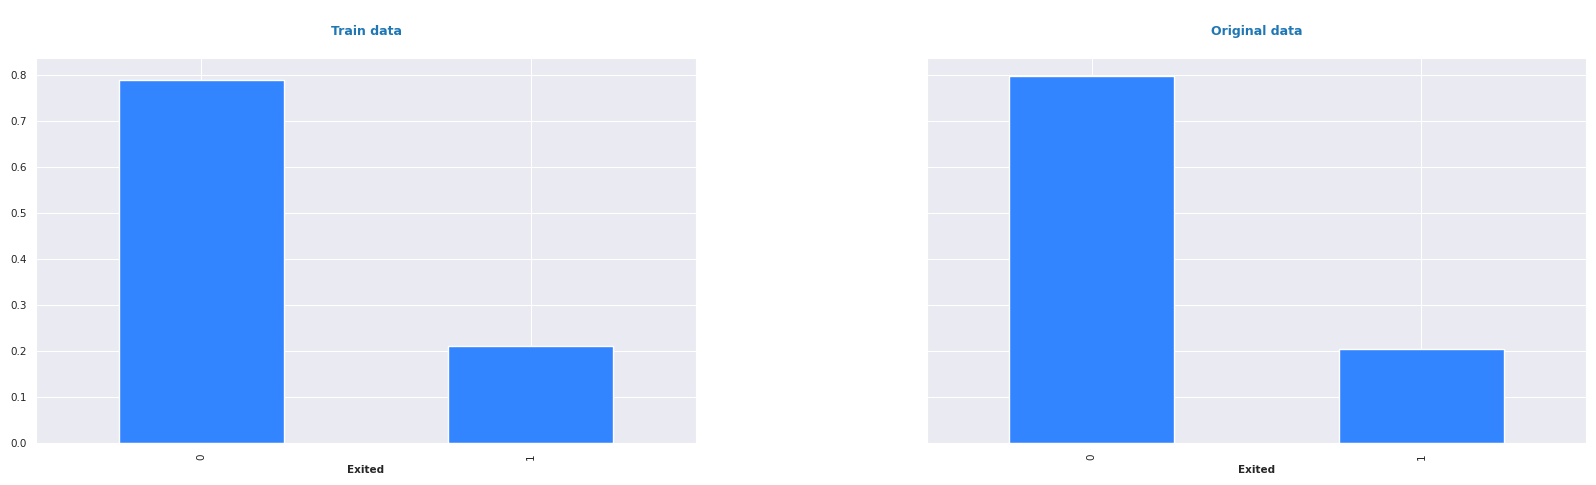


CPU times: user 595 ms, sys: 314 ms, total: 908 ms
Wall time: 588 ms


In [11]:
%%time 

if CFG.ftre_plots_req == "Y":
    fig, axes = plt.subplots(1,2, figsize = (20, 5), sharey = True, gridspec_kw = {'wspace': 0.35});
    
    for i, df in tqdm(enumerate([pp.train, pp.original]), "Target plot ---> "):
        ax= axes[i];
        a = df[CFG.target].value_counts(normalize = True);
        a.sort_index().plot.bar(color = '#3385ff', ax = ax);
        df_name = 'Train' if i == 0 else "Original";
        _ = ax.set_title(f"\n{df_name} data\n", **CFG.title_specs);
        
    plt.tight_layout();
    plt.show();
    
print();
collect();

<a id="5.5"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > CONTINUOUS COLUMN PLOTS<br><div>

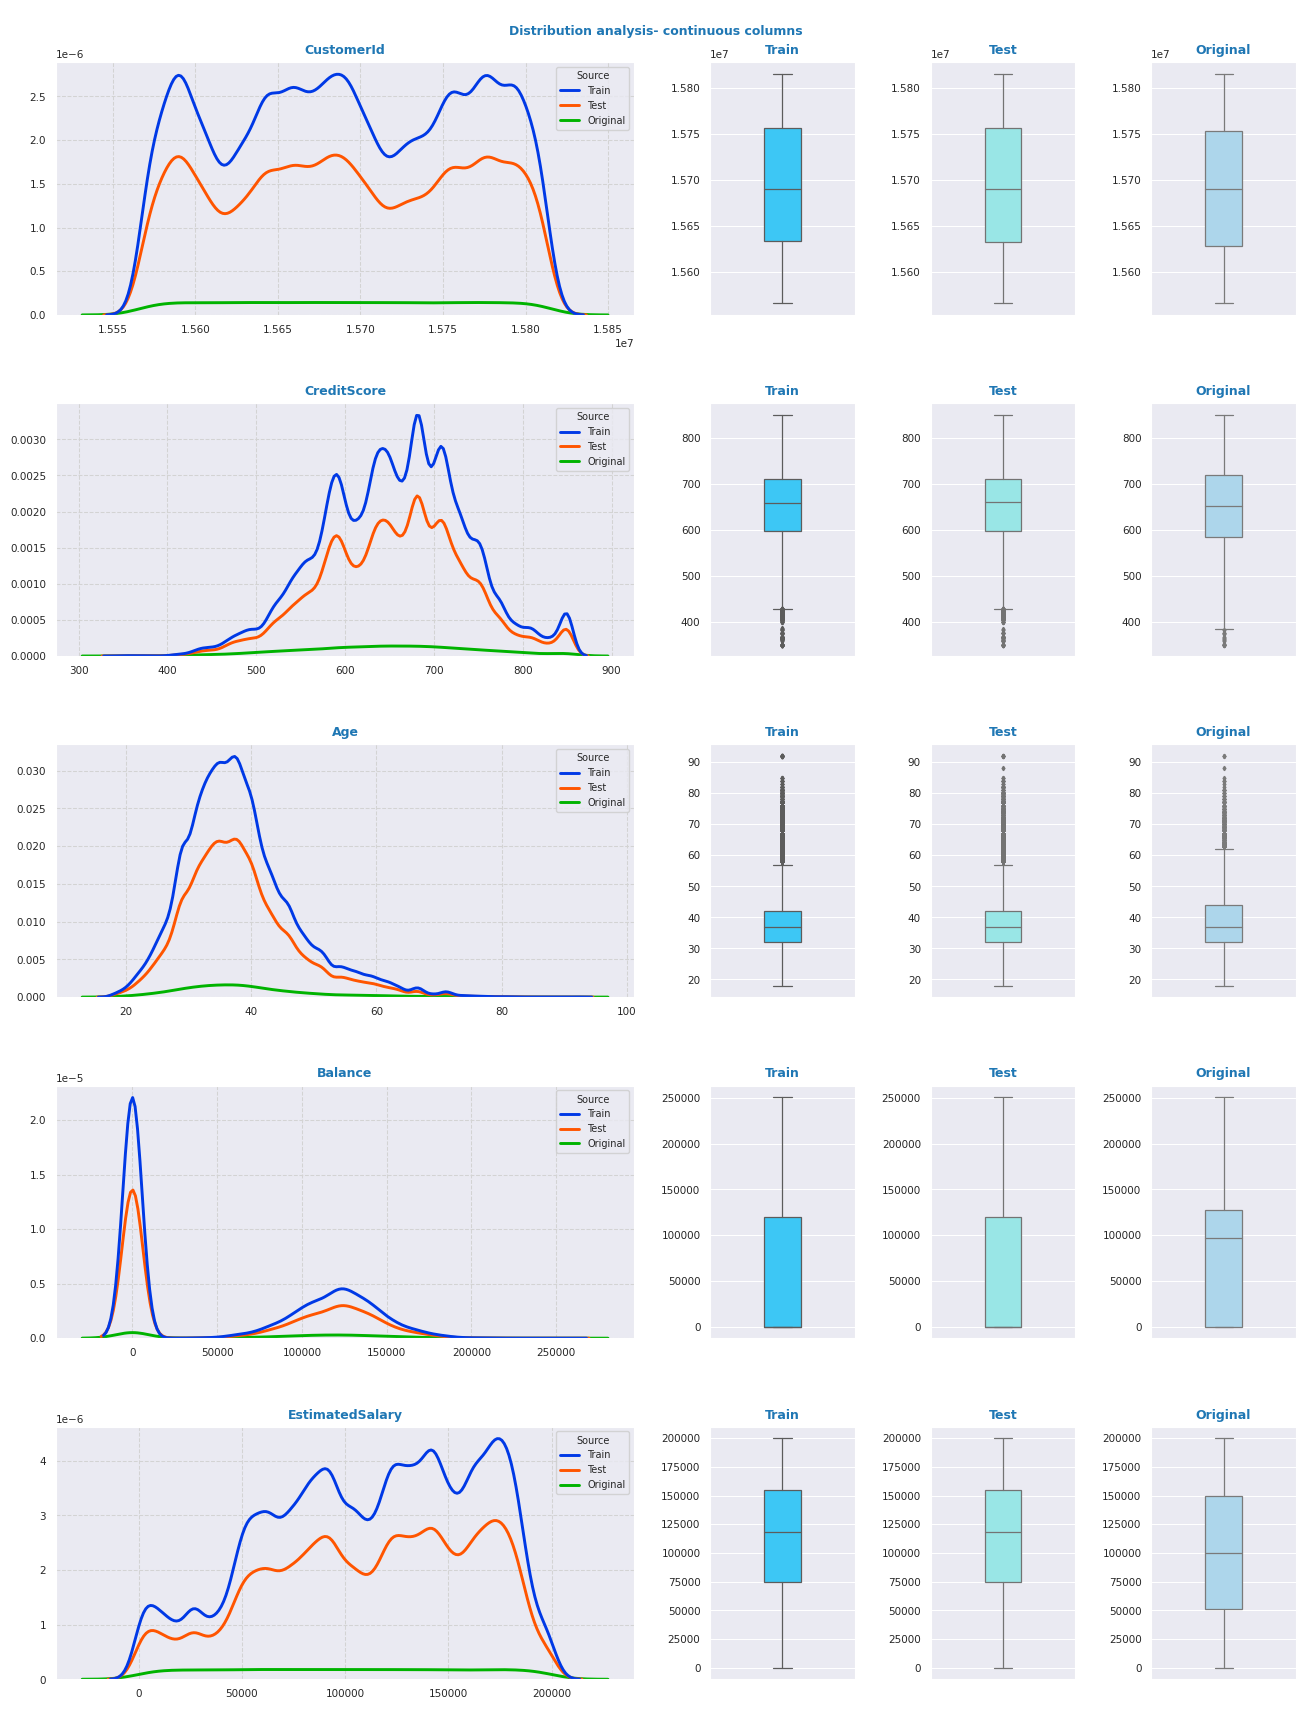


CPU times: user 10.4 s, sys: 5.12 s, total: 15.5 s
Wall time: 9.87 s


In [12]:
%%time 

if CFG.ftre_plots_req == "Y":
    df = pd.concat([pp.train[cont_cols].assign(Source = 'Train'), 
                    pp.test[cont_cols].assign(Source = 'Test'),
                    pp.original[cont_cols].assign(Source = "Original")
                   ], 
                   axis=0, ignore_index = True
                  );
    
    fig, axes = plt.subplots(len(cont_cols), 4 ,figsize = (16, len(cont_cols) * 4.2), 
                             gridspec_kw = {'hspace': 0.35, 'wspace': 0.3, 'width_ratios': [0.80, 0.20, 0.20, 0.20]});
    
    for i,col in enumerate(cont_cols):
        ax = axes[i,0];
        sns.kdeplot(data = df[[col, 'Source']], x = col, hue = 'Source', 
                    palette = ['#0039e6', '#ff5500', '#00b300'], 
                    ax = ax, linewidth = 2.1
                   );
        ax.set_title(f"\n{col}", **CFG.title_specs);
        ax.grid(**CFG.grid_specs);
        ax.set(xlabel = '', ylabel = '');
        
        ax = axes[i,1];
        sns.boxplot(data = df.loc[df.Source == 'Train', [col]], y = col, width = 0.25,
                    color = '#33ccff', saturation = 0.90, linewidth = 0.90, 
                    fliersize= 2.25,
                    ax = ax);
        ax.set(xlabel = '', ylabel = '');
        ax.set_title(f"Train", **CFG.title_specs);
        
        ax = axes[i,2];
        sns.boxplot(data = df.loc[df.Source == 'Test', [col]], y = col, width = 0.25, fliersize= 2.25,
                    color = '#80ffff', saturation = 0.6, linewidth = 0.90, 
                    ax = ax); 
        ax.set(xlabel = '', ylabel = '');
        ax.set_title(f"Test", **CFG.title_specs);
        
        ax = axes[i,3];
        sns.boxplot(data = df.loc[df.Source == 'Original', [col]], y = col, width = 0.25, fliersize= 2.25,
                    color = '#99ddff', saturation = 0.6, linewidth = 0.90, 
                    ax = ax); 
        ax.set(xlabel = '', ylabel = '');
        ax.set_title(f"Original", **CFG.title_specs);
              
    plt.suptitle(f"\nDistribution analysis- continuous columns\n", **CFG.title_specs, 
                 y = 0.905, x = 0.50
                );
    plt.tight_layout();
    plt.show();
    
print();
collect();

In [13]:
%%time 

# Calculating skewness across columns:-
skew_df = pd.DataFrame(index = cont_cols);
for col, df in {"Train": pp.train[cont_cols], 
                "Test": pp.test[cont_cols], 
                "Original": pp.original[cont_cols]}.items():   
    skew_df = \
    pd.concat([skew_df, 
               df.drop(columns = [CFG.target, "Source", "id"], errors = "ignore").skew()],
               axis=1).rename({0: col}, axis=1);

PrintColor(f"\nSkewness across independent features\n");
display(skew_df.transpose().style.format(precision = 2).background_gradient("Pastel2"));

collect();
print();


Skewness across independent features



,CustomerId,CreditScore,Age,Balance,EstimatedSalary
Train,-0.02,-0.06,0.97,0.38,-0.31
Test,-0.02,-0.06,0.97,0.39,-0.31
Original,0.00,-0.07,1.01,-0.14,0.00



CPU times: user 197 ms, sys: 4.19 ms, total: 201 ms
Wall time: 200 ms


<a id="5.6"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > CATEGORY COLUMN PLOTS<br><div>

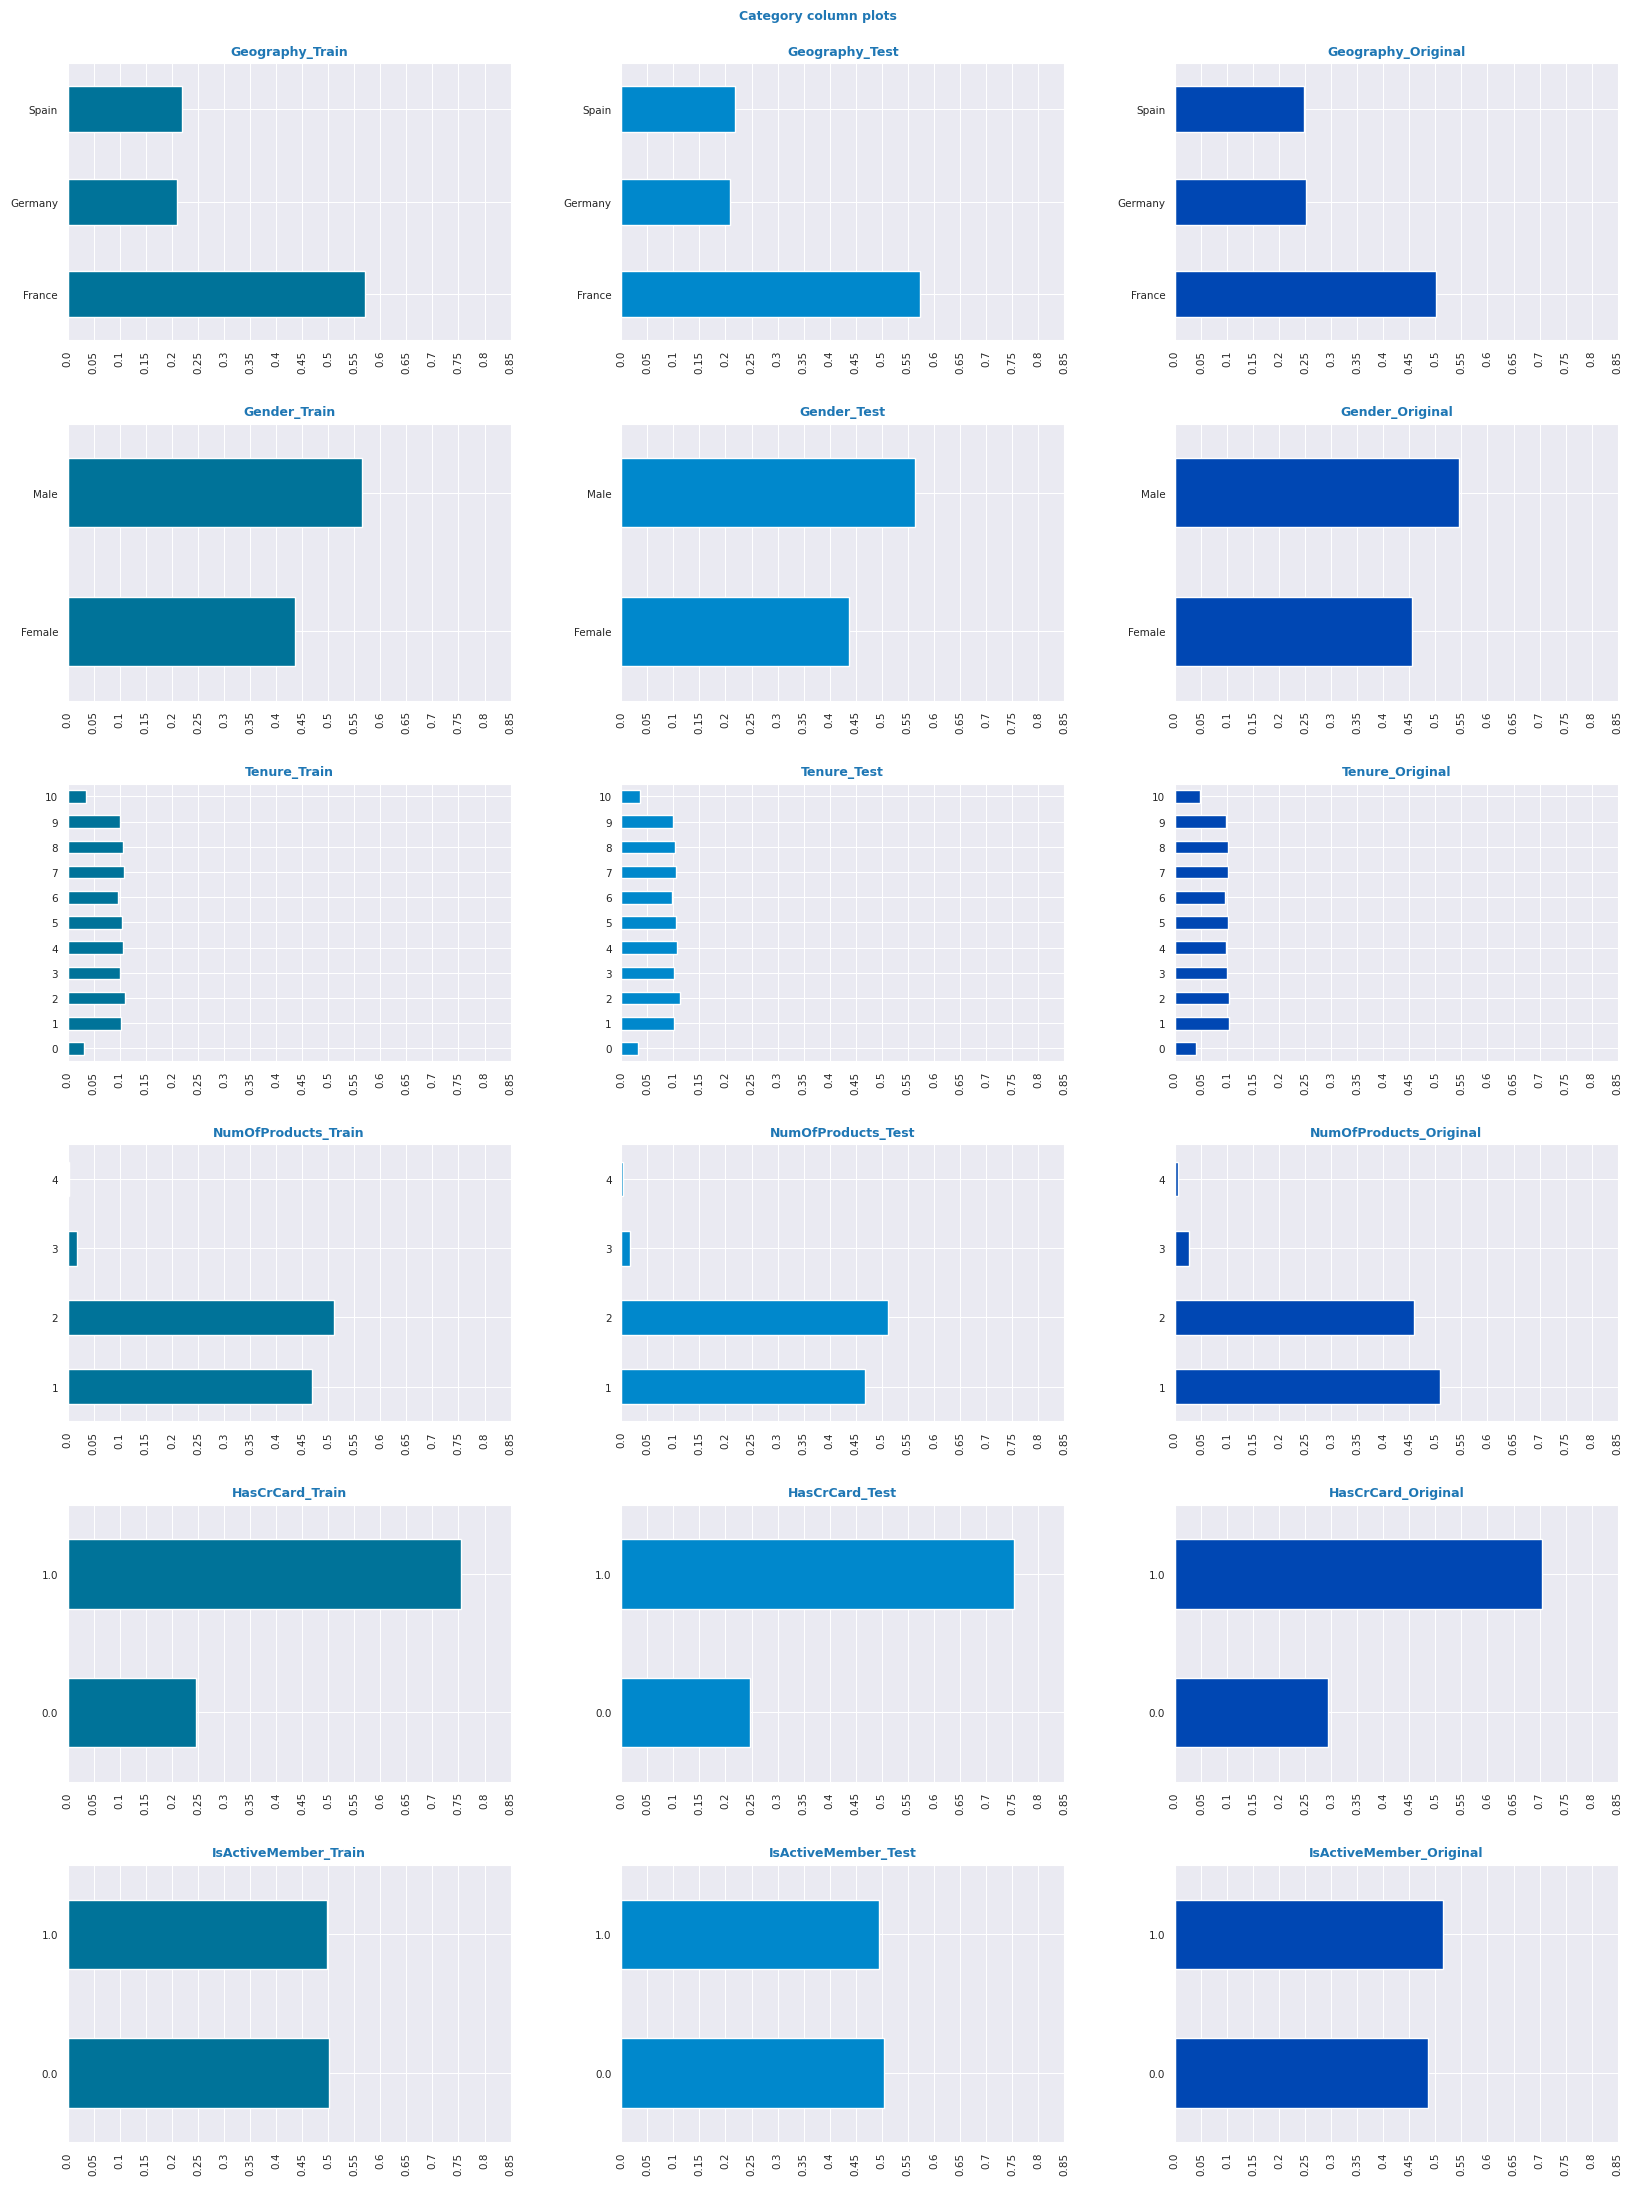


CPU times: user 4.89 s, sys: 223 ms, total: 5.11 s
Wall time: 4.87 s


In [14]:
%%time 

if CFG.ftre_plots_req == "Y" and cat_cols != []:
    fig, axes = plt.subplots(len(cat_cols), 3, figsize = (20, len(cat_cols)* 4.5), 
                             gridspec_kw = {'wspace': 0.25, 'hspace': 0.3});

    for i, col in enumerate(cat_cols):
        ax = axes[i, 0];
        a = pp.train[col].value_counts(normalize = True);
        a.sort_index().plot.barh(ax = ax, color = '#007399');
        ax.set_title(f"{col}_Train", **CFG.title_specs);
        ax.set_xticks(np.arange(0.0, 0.9, 0.05), 
                      labels = np.round(np.arange(0.0, 0.9, 0.05),2), 
                      rotation = 90
                     );
        ax.set(xlabel = '', ylabel = '');
        del a;

        ax = axes[i, 1];
        a = pp.test[col].value_counts(normalize = True);
        a.sort_index().plot.barh(ax = ax, color = '#0088cc');
        ax.set_title(f"{col}_Test", **CFG.title_specs);
        ax.set_xticks(np.arange(0.0, 0.9, 0.05), 
                      labels = np.round(np.arange(0.0, 0.9, 0.05),2), 
                      rotation = 90
                     );
        ax.set(xlabel = '', ylabel = '');
        del a;
        
        ax = axes[i, 2];
        a = pp.original[col].value_counts(normalize = True);
        a.sort_index().plot.barh(ax = ax, color = '#0047b3');
        ax.set_title(f"{col}_Original", **CFG.title_specs);
        ax.set_xticks(np.arange(0.0, 0.9, 0.05), 
                      labels = np.round(np.arange(0.0, 0.9, 0.05),2), 
                      rotation = 90
                     );
        ax.set(xlabel = '', ylabel = '');
        del a;       
    
    plt.suptitle(f"Category column plots", **CFG.title_specs, y= 0.90);
    plt.tight_layout();
    plt.show();
    
print();
collect();


<a id="5.7"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > FEATURE INTERACTION AND UNIVARIATE RELATIONS<br><div>
    


In [15]:
%%time 

def MakeCorrPlot(df: pd.DataFrame, data_label:str, figsize = (30, 9)):
    """
    This function develops the correlation plots for the given dataset
    """;
    
    fig, axes = plt.subplots(1,2, figsize = figsize, gridspec_kw = {'hspace': 0.2, 'wspace': 0.1},
                             sharey = True
                            );
    
    for i, method in enumerate(['pearson', 'spearman']):
        corr_ = df.drop(columns = ['id', 'Source'], errors = 'ignore').corr(method = method);
        ax = axes[i];
        sns.heatmap(data = corr_,  
                    annot= True,
                    fmt= '.2f', 
                    cmap = 'Blues',
                    annot_kws= {'fontweight': 'bold','fontsize': 6.75}, 
                    linewidths= 1.5, 
                    linecolor='white', 
                    cbar= False, 
                    mask= np.triu(np.ones_like(corr_)),
                    ax= ax
                   );
        ax.set_title(f"\n{method.capitalize()} correlation- {data_label}\n", **CFG.title_specs);
        
    collect();
    print();

print();
collect();


CPU times: user 168 ms, sys: 1.99 ms, total: 170 ms
Wall time: 168 ms


<a id="5.12"></a>
## <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0059b3; border-bottom: 8px solid #e6e6e6" > INFERENCES<br> <div>

<div style= "font-family: Cambria; letter-spacing: 0px; color:#000000; font-size:110%; text-align:left;padding:3.0px; background: #f2f2f2" >
1. Features are positively and negatively skewed and are all non-negative. Feature transforms may be useful for non-tree models<br>
2. Outlier treatment could be considered as an option considering outlier presence across all columns in the data<br>
3. Higher correlation between quite a few columns may necessitate methods like PCA <br>
</div>

<a id="6"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > DATA TRANSFORMS <br><div> 
    
This section aims at creating secondary features, scaling and if necessary, conjoining the competition training and original data tables<br>


In [16]:
%%time 

# Data transforms:-
class Xformer(TransformerMixin, BaseEstimator):
    """
    This class adds secondary features to the existing data using simple interactions
    """;
    
    def __init__(self): 
        self.sec_ftre_req = CFG.sec_ftre_req;
    
    def fit(self, X, y= None, **params):
        return self;
    
    @staticmethod
    def _reduce_mem(df: pd.DataFrame):
        "This method reduces memory for numeric columns in the dataframe";
        
        numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
        start_mem = df.memory_usage().sum() / 1024**2;
        
        for col in df.columns:
            col_type = df[col].dtypes
            
            if col_type in numerics:
                c_min = df[col].min();
                c_max = df[col].max();

                if "int" in str(col_type):
                    if c_min >= np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min >= np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min >= np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min >= np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)  
                else:
                    if c_min >= np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                        df[col] = df[col].astype(np.float16)
                    if c_min >= np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)  

        end_mem = df.memory_usage().sum() / 1024**2
    
        PrintColor(f"Start - end memory:- {start_mem:5.2f} - {end_mem:5.2f} Mb");
        return df;
    
    def transform(self, X, y= None, **params):
        """
        This method adds secondary features to the existing data
        It also encodes category columns manually
        """;

        df = X.copy();
        if self.sec_ftre_req == "Y":
            df['Age_Grp'] = \
            np.select([df['Age'] < 21, df['Age'] <= 30, df['Age'] <= 40, df['Age'] <= 50, df['Age'] <= 60, df['Age'] > 60],
                      [0,1,2,3,4,5], 6).astype(np.uint8);
            
        self.op_cols = df.columns;
        df = self._reduce_mem(df);
        return df;
    
    def get_feature_names_in(self, X, y=None, **params): 
        return self.ip_cols;    
    
    def get_feature_names_out(self, X, y=None, **params): 
        return self.op_cols;
    
collect();
print();


CPU times: user 166 ms, sys: 523 µs, total: 166 ms
Wall time: 165 ms


In [17]:
%%time

PrintColor(f"\n{'='* 20} Data transformation {'='* 20} \n");

ytrain = train[CFG.target];
Xtrain = train.drop(columns = [CFG.target]);
Xtest  = test.copy(deep = True);

PrintColor(f"\n---> Train data\n");
display(Xtrain.head(5).style.format(precision = 2));
PrintColor(f"\n---> Test data\n");
display(Xtest.head(5).style.format(precision = 2));

print();
xform  = Pipeline(steps = [("OHE", OneHotEncoder(cols = ["Geography", "Gender"], use_cat_names = True)),
                           ("ODE", OrdinalEncoder(cols = ["Surname"])),
                           ("S1", Xformer())
                          ]
                 );                    
Xtrain = xform.fit_transform(Xtrain, ytrain);
Xtest  = xform.transform(Xtest);
print();

PrintColor(f"\n---> Train data columns after data pipeline\n");
pprint(Xtrain.columns);

PrintColor(f"\n---> Test data columns after data pipeline\n");
pprint(Xtest.columns);
PrintColor(f"\n---> Train-test shape after pipeline = {Xtrain.shape} {Xtest.shape}");

PrintColor(f"\n---> Dropping duplicates in the train data");
_ = pd.concat([Xtrain, ytrain], axis=1).drop_duplicates(subset = Xtrain.columns[0:-1].to_list());
_.index = range(len(_));
Xtrain, ytrain = _.drop(columns = [CFG.target]), _[CFG.target];
del _;
PrintColor(f"---> Train-test shape after duplicate removal = {Xtrain.shape} {Xtest.shape}");

print();
collect();



==================== Data transformation ==================== 


---> Train data



,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Source
id,,,,,,,,,,,,,
0,15674932,Okwudilichukwu,668,France,Male,33.00,3,0.00,2,1.00,0.00,181449.97,Competition
1,15749177,Okwudiliolisa,627,France,Male,33.00,1,0.00,2,1.00,1.00,49503.50,Competition
2,15694510,Hsueh,678,France,Male,40.00,10,0.00,2,1.00,0.00,184866.69,Competition
3,15741417,Kao,581,France,Male,34.00,2,148882.54,1,1.00,1.00,84560.88,Competition
4,15766172,Chiemenam,716,Spain,Male,33.00,5,0.00,2,1.00,1.00,15068.83,Competition



---> Test data



,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Source
id,,,,,,,,,,,,,
165034,15773898,Lucchese,586,France,Female,23.00,2,0.00,2,0.00,1.00,160976.75,Competition
165035,15782418,Nott,683,France,Female,46.00,2,0.00,1,1.00,0.00,72549.27,Competition
165036,15807120,K?,656,France,Female,34.00,7,0.00,2,1.00,0.00,138882.09,Competition
165037,15808905,O'Donnell,681,France,Male,36.00,8,0.00,1,1.00,0.00,113931.57,Competition
165038,15607314,Higgins,752,Germany,Male,38.00,10,121263.62,1,1.00,0.00,139431.00,Competition



Start - end memory:- 22.87 -  8.68 Mb
Start - end memory:- 14.37 -  5.46 Mb


---> Train data columns after data pipeline

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography_France',
       'Geography_Spain', 'Geography_Germany', 'Gender_Male', 'Gender_Female',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Source', 'Age_Grp'],
      dtype='object')

---> Test data columns after data pipeline

Index(['CustomerId', 'Surname', 'CreditScore', 'Geography_France',
       'Geography_Spain', 'Geography_Germany', 'Gender_Male', 'Gender_Female',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Source', 'Age_Grp'],
      dtype='object')

---> Train-test shape after pipeline = (175030, 17) (110023, 17)

---> Dropping duplicates in the train data
---> Train-test shape after duplicate removal = (175030, 17) (110023, 17)

CPU times: user 782 ms, sys: 64.9 ms, total: 847

In [18]:
%%time 

# Shortlisting the duplicate data between train and test dataframes for post-processing:-
join_cols = Xtrain.columns[0:-1].to_list();

dups_df = \
Xtrain.\
reset_index(names = "id").\
assign(Label = "Train").\
merge(Xtest.reset_index().assign(Label = "Test"),
      how = "inner", on = join_cols, suffixes = ("_train", "_test")).\
drop(columns = join_cols).\
merge(ytrain, how = "inner", left_on = "id_train", right_index = True)\
[['id_train', 'id_test', CFG.target]].\
drop_duplicates(subset = ['id_test']);

del join_cols;

PrintColor(f"\n---> Train-test duplicate data glimpse- shape = {dups_df.shape}");
display(dups_df.head(10).style.format(precision = 3));
dups_df.to_csv(f"Duplicates.csv", index = None);

collect();
print();


---> Train-test duplicate data glimpse- shape = (0, 3)


,id_train,id_test,Exited



CPU times: user 296 ms, sys: 14.4 ms, total: 311 ms
Wall time: 311 ms


In [19]:
%%time 

# Sampling the data for testing purposes:-
if CFG.test_req == "Y":
    _ = pd.concat([Xtrain, ytrain], axis=1).groupby([CFG.target]).sample(frac = CFG.test_sample_frac);
    Xtrain = _.drop(columns = [CFG.target]);
    ytrain = _[CFG.target];
    Xtrain.index = range(len(Xtrain));
    ytrain.index = Xtrain.index;
    del _;
    
    PrintColor(f"\n---> Train size after sampling for syntax check = {Xtrain.shape} {ytrain.shape}");
    
collect();
print();


---> Train size after sampling for syntax check = (4376, 17) (4376,)

CPU times: user 189 ms, sys: 1.29 ms, total: 190 ms
Wall time: 190 ms


<a id="7"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:black; font-size:120%; text-align:left;padding:3.0px; background: #cceeff; border-bottom: 8px solid #004466" > MODEL TRAINING <br><div> 
   

In [20]:
%%time 

class OptunaEnsembler:
    """
    This is the Optuna ensemble class-
    Source- https://www.kaggle.com/code/arunklenin/ps3e26-cirrhosis-survial-prediction-multiclass
    """;
    
    def __init__(self):
        self.study        = None;
        self.weights      = None;
        self.random_state = CFG.state;
        self.n_trials     = CFG.ntrials;
        self.direction    = CFG.metric_obj;
        
    def ScoreMetric(self, ytrue, ypred):
        """
        This is the metric function for the competition
        """;
        return brier_score_loss(ytrue, ypred);

    def _objective(self, trial, y_true, y_preds):
        """
        This method defines the objective function for the ensemble
        """;
        
        if isinstance(y_preds, pd.DataFrame) or isinstance(y_preds, np.ndarray):
            weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(y_preds.shape[-1])];
            axis = 1;
        elif isinstance(y_preds, list):
            weights = [trial.suggest_float(f"weight{n}", 0, 1) for n in range(len(y_preds))];
            axis = 0;

        # Calculating the weighted prediction:-
        weighted_pred  = np.average(np.array(y_preds), axis = axis, weights = weights);
        score          = self.ScoreMetric(y_true, weighted_pred);
        return score;

    def fit(self, y_true, y_preds):
        "This method fits the Optuna objective on the fold level data";
        
        optuna.logging.set_verbosity = optuna.logging.ERROR;
        self.study = \
        optuna.create_study(sampler    = TPESampler(seed = self.random_state), 
                            pruner     = HyperbandPruner(),
                            study_name = "Ensemble", 
                            direction  = self.direction,
                           );
        
        obj = partial(self._objective, y_true = y_true, y_preds = y_preds);
        self.study.optimize(obj, n_trials = self.n_trials);
               
        if isinstance(y_preds, list):
            self.weights = [self.study.best_params[f"weight{n}"] for n in range(len(y_preds))];
        else:
            self.weights = [self.study.best_params[f"weight{n}"] for n in range(y_preds.shape[-1])];
        clear_output();

    def predict(self, y_preds):
        "This method predicts using the fitted Optuna objective";
        
        assert self.weights is not None, 'OptunaWeights error, must be fitted before predict';
        
        if isinstance(y_preds, list):
            weighted_pred = np.average(np.array(y_preds), axis=0, weights = self.weights);
        else:
            weighted_pred = np.average(np.array(y_preds), axis=1, weights = self.weights);
        return weighted_pred;

    def fit_predict(self, y_true, y_preds):
        """
        This method fits the Optuna objective on the fold data, then predicts the test set
        """;
        self.fit(y_true, y_preds);
        return self.predict(y_preds);
    
    def weights(self):
        return self.weights;
    
print();
collect();


CPU times: user 162 ms, sys: 3.3 ms, total: 165 ms
Wall time: 164 ms


In [21]:
%%time 

class MdlDeveloper(CFG):
    """
    This class implements the training pipeline elements-
    1. Initializes the Model predictions
    2. Trains and infers models
    3. Returns the OOF and model test set predictions
    """;
    
    def __init__(self, Xtrain, ytrain, Xtest, sel_cols, cat_cols, **kwarg):
        """
        In this method, we initialize the below-
        1. Train-test data, selected columns
        2. Metric, custom scorer, model and cv object
        3. Output tables for score and predictions
        """;
        
        self.Xtrain      = Xtrain;
        self.ytrain      = ytrain;
        self.y_grp       = ytrain;
        self.Xtest       = Xtest;
        self.sel_cols    = sel_cols;
        self.cat_cols    = cat_cols;
     
        self._DefineModels();
        self.cv          = self.all_cv[self.mdlcv_mthd];
        self.methods     = list(self.Mdl_Master.keys());
        self.OOF_Preds   = pd.DataFrame();
        self.Mdl_Preds   = pd.DataFrame();
        self.Scores      = pd.DataFrame(columns = self.methods + ["Ensemble"], 
                                        index = range(self.n_splits * self.n_repeats)
                                       ); 
        self.TrainScores = pd.DataFrame(columns = self.methods, 
                                        index = range(self.n_splits * self.n_repeats)
                                       ); 
        self.mdlscorer   = make_scorer(self.ScoreMetric, 
                                       greater_is_better = True,
                                       needs_proba       = True,
                                       needs_threshold   = False,
                                      );  
        
        PrintColor(f"\n---> Selected model options-");
        try:
            with np.printoptions(linewidth = 150):
                pprint(np.array(self.methods), depth = 1, width = 100, indent = 5);
        except:
            pprint(self.methods, depth = 1, width = 100, indent = 5);
              
    def _DefineModels(self):
        """
        This method initiliazes models for the analysis
        It also initializes the CV methods and class-weights that could be tuned going ahead.
        """;
        
        # Commonly used CV strategies for later usage:-
        self.all_cv = \
        {'KF'  : KFold(n_splits= CFG.n_splits, shuffle = True, random_state= CFG.state),
         'RKF' : RKF(n_splits= CFG.n_splits, n_repeats = CFG.n_repeats, random_state= CFG.state),
         'RSKF': RSKF(n_splits= CFG.n_splits, n_repeats = CFG.n_repeats, random_state= CFG.state),
         'SKF' : SKF(n_splits= CFG.n_splits, shuffle = True, random_state= CFG.state)
        };
           
        self.Mdl_Master = \
        {                      
         'XGB1C': XGBC(**{'tree_method'           : "gpu_hist" if CFG.gpu_switch == "ON" else "hist",
                          'objective'             : 'binary:logistic',
                          'eval_metric'           : "auc",
                          'random_state'          : self.state,
                          'colsample_bytree'      : 0.25,
                          'learning_rate'         : 0.07,
                          'max_depth'             : 8,
                          'n_estimators'          : 1100,                         
                          'reg_alpha'             : 0.09,
                          'reg_lambda'            : 0.70,
                          'min_child_weight'      : 22,
                          'early_stopping_rounds' : CFG.nbrnd_erly_stp,
                          'verbosity'             : 0,
                          "scale_pos_weight"      : 0.965, 
                         }
                      ),
            
         'XGB2C': XGBC(**{'tree_method'           : "gpu_hist" if CFG.gpu_switch == "ON" else "hist",
                          'objective'             : 'binary:logistic',
                          'eval_metric'           : "auc",
                          'random_state'          : self.state,
                          'colsample_bytree'      : 0.40,
                          'learning_rate'         : 0.06,
                          'max_depth'             : 9,
                          'n_estimators'          : 2500,                         
                          'reg_alpha'             : 0.12,
                          'reg_lambda'            : 0.8,
                          'min_child_weight'      : 15,
                          'early_stopping_rounds' : CFG.nbrnd_erly_stp,
                          'verbosity'             : 0,
                          "scale_pos_weight"      : 0.9,
                         }
                      ),

         'XGB3C': XGBC(**{'tree_method'           : "gpu_hist" if CFG.gpu_switch == "ON" else "hist",
                          'objective'             : 'binary:logistic',
                          'eval_metric'           : "auc",
                          'random_state'          : self.state,
                          'colsample_bytree'      : 0.5,
                          'learning_rate'         : 0.055,
                          'max_depth'             : 9,
                          'n_estimators'          : 3000,                         
                          'reg_alpha'             : 0.2,
                          'reg_lambda'            : 0.6,
                          'min_child_weight'      : 25,
                          'early_stopping_rounds' : CFG.nbrnd_erly_stp,
                          'verbosity'             : 0,
                          "scale_pos_weight"      : 0.9325,
                         }
                      ),
            
         'XGB4C': XGBC(**{'tree_method'           : "gpu_hist" if CFG.gpu_switch == "ON" else "hist",
                          'objective'             : 'binary:logistic',
                          'eval_metric'           : "auc",
                          'random_state'          : self.state,
                          'colsample_bytree'      : 0.80,
                          'learning_rate'         : 0.082,
                          'max_depth'             : 7,
                          'n_estimators'          : 2000,                         
                          'reg_alpha'             : 0.005,
                          'reg_lambda'            : 0.95,
                          'min_child_weight'      : 26,
                          'early_stopping_rounds' : CFG.nbrnd_erly_stp,
                          'verbosity'             : 0,
                          "scale_pos_weight"      : 0.85, 
                         }
                      ),
              
         'LGBM1C':LGBMC(**{'device'              : "gpu" if CFG.gpu_switch == "ON" else "cpu",
                           'objective'           : 'binary',
                           'boosting_type'       : 'gbdt',
                           'metric'              : "auc",
                           'random_state'        : self.state,
                           'colsample_bytree'    : 0.56,
                           'subsample'           : 0.35,
                           'learning_rate'       : 0.05,
                           'max_depth'           : 8,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 140,
                           'reg_alpha'           : 0.14,
                           'reg_lambda'          : 0.85,
                           'verbosity'           : -1,
                           "scale_pos_weight"    : 0.9, 
                          }
                       ),
            
         'LGBM2C':LGBMC(**{'device'              : "gpu" if CFG.gpu_switch == "ON" else "cpu",
                           'objective'           : 'binary',
                           'boosting_type'       : 'gbdt',
                           'data_sample_strategy': "goss",
                           'metric'              : "auc",
                           'random_state'        : self.state,
                           'colsample_bytree'    : 0.20,
                           'subsample'           : 0.25,
                           'learning_rate'       : 0.0725,
                           'max_depth'           : 9,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 120, 
                           'reg_alpha'           : 0.15,
                           'reg_lambda'          : 0.90,
                           'verbosity'           : -1,
                           "scale_pos_weight"    : 0.8, 
                          }
                       ),
            
         'LGBM3C':LGBMC(**{'device'              : "gpu" if CFG.gpu_switch == "ON" else "cpu",
                           'objective'           : 'binary',
                           'boosting_type'       : 'gbdt',
                           'metric'              : "auc",
                           'random_state'        : self.state,
                           'colsample_bytree'    : 0.45,
                           'subsample'           : 0.45,
                           'learning_rate'       : 0.06,
                           'max_depth'           : 6,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 125, 
                           'reg_alpha'           : 0.05,
                           'reg_lambda'          : 0.95,
                           'verbosity'           : -1,
                           "scale_pos_weight"    : 0.85,
                          }
                       ), 
            
         'LGBM4C':LGBMC(**{'device'              : "gpu" if CFG.gpu_switch == "ON" else "cpu",
                           'objective'           : 'binary',
                           'boosting_type'       : 'gbdt',
                           'metric'              : "auc",
                           'random_state'        : self.state,
                           'colsample_bytree'    : 0.55,
                           'subsample'           : 0.55,
                           'learning_rate'       : 0.085,
                           'max_depth'           : 9,
                           'n_estimators'        : 3000,
                           'num_leaves'          : 105, 
                           'reg_alpha'           : 0.08,
                           'reg_lambda'          : 0.995,
                           'verbosity'           : -1,
                          }
                       ),
            
        "CB1C" :  CBC(**{'task_type'           : "GPU" if CFG.gpu_switch == "ON" else "CPU",
                         'objective'           : 'Logloss',
                         'eval_metric'         : "AUC",
                         'bagging_temperature' : 0.1,
                         'colsample_bylevel'   : 0.88,
                         'iterations'          : 3000,
                         'learning_rate'       : 0.065,
                         'od_wait'             : 12,
                         'max_depth'           : 7,
                         'l2_leaf_reg'         : 1.75,
                         'min_data_in_leaf'    : 25,
                         'random_strength'     : 0.1, 
                         'max_bin'             : 100,
                         'verbose'             : 0,
                         'use_best_model'      : True,
                         "scale_pos_weight"    : 0.90,
                        }
                     ),
            
        "CB2C" :  CBC(**{'task_type'           : "GPU" if CFG.gpu_switch == "ON" else "CPU",
                         'objective'           : 'Logloss',
                         'eval_metric'         : "AUC",
                         'bagging_temperature' : 0.5,
                         'colsample_bylevel'   : 0.50,
                         'iterations'          : 2500,
                         'learning_rate'       : 0.08,
                         'od_wait'             : 24,
                         'max_depth'           : 8,
                         'l2_leaf_reg'         : 1.235,
                         'min_data_in_leaf'    : 25,
                         'random_strength'     : 0.35, 
                         'max_bin'             : 160,
                         'verbose'             : 0,
                         'use_best_model'      : True,
                         "scale_pos_weight"    : 0.825,
                        }
                     ),
        
        "GBC" : GBC(loss                = 'log_loss',
                    learning_rate       = 0.065,
                    n_estimators        = 850,
                    subsample           = 0.6,
                    min_samples_leaf    = 30,
                    max_depth           = 8,
                    random_state        = self.state,
                    verbose             = 0,
                    validation_fraction = 0.1,
                    n_iter_no_change    = 50,
                   )  
        };
        return self;
    
    def ScoreMetric(self, ytrue, ypred):
        """
        This is the metric function for the competition scoring
        """;
        return roc_auc_score(ytrue, ypred);
    
    def ClbMetric(self, ytrue, ypred):
        """
        This is the calibration metric
        """;
        return brier_score_loss(ytrue, ypred);
        
    def PostProcessPred(self, ypred):
        """
        This is an optional post-processing method
        """;
        return np.clip(ypred,a_min = 0,a_max = 1);
    
    def TrainMdl(self, test_preds_req: str = "Y"):
        """
        This method trains and infers from the model suite and returns the predictions and scores
        It optionally predicts the test set too, if desired by the user
        """;

        # Initializing I-O:- 
        X,y, Xt    = self.Xtrain[self.sel_cols], self.ytrain.copy(deep = True), self.Xtest[self.sel_cols];
        cols_drop  = ['Source', "id"];
        ens        = OptunaEnsembler();
        
        self.FtreImp = pd.DataFrame(columns = self.methods, 
                                    index   = [c for c in self.sel_cols if c not in cols_drop]
                                   ).fillna(0);
        
        # Making CV folds:-        
        for fold_nb, (train_idx, dev_idx) in tqdm(enumerate(self.cv.split(X, self.y_grp))):
            Xtr  = X.iloc[train_idx].drop(columns = cols_drop, errors = 'ignore');  
            Xdev = X.iloc[dev_idx].query("Source == 'Competition'").drop(columns = cols_drop, errors = 'ignore');    
            ytr  = y.loc[y.index.isin(Xtr.index)];
            ydev = y.loc[y.index.isin(Xdev.index)];
                   
            # Initializing the OOF and test set predictions:-            
            oof_preds = pd.DataFrame(columns = self.methods, index = Xdev.index);
            mdl_preds = pd.DataFrame(columns = self.methods, index = Xt.index);
            
            PrintColor(f"\n{'=' * 5} FOLD {fold_nb + 1} {'=' * 5}\n");
            # Initializing models across methods:-
            for method in tqdm(self.methods):
                model = Pipeline(steps = [("M", self.Mdl_Master.get(method))]); 

                # Fitting the model:-          
                if "CB" in method:    
                    model.fit(Xtr, ytr, 
                              M__eval_set = [(Xdev, ydev)], 
                              M__verbose = 0,
                              M__early_stopping_rounds = CFG.nbrnd_erly_stp,
                             ); 

                elif "LGBM" in method:
                    model.fit(Xtr, ytr, 
                              M__eval_set = [(Xdev, ydev)], 
                              M__callbacks = [log_evaluation(0), 
                                              early_stopping(stopping_rounds = CFG.nbrnd_erly_stp, 
                                                             verbose = False,),
                                             ],
                             ); 

                elif "XGB" in method:
                     model.fit(Xtr, ytr, 
                               M__eval_set = [(Xdev, ydev)], 
                               M__verbose  = 0,
                              );            

                else: 
                    model.fit(Xtr, ytr);
                    
                # Collating feature importance:-
                try: 
                    self.FtreImp[method] += model["M"].feature_importances_;
                except: 
                    pass;
                    
                # Collecting predictions and scores and post-processing OOF based on model method:-
                dev_preds    = model.predict_proba(Xdev)[:,1];
                train_preds  = model.predict_proba(Xtr)[:,1];
                tr_score     = self.ScoreMetric(ytr.values.flatten(),train_preds);
                score        = self.ScoreMetric(ydev.values.flatten(),dev_preds);
                         
                PrintColor(f"OOF = {score:.5f} | Train = {tr_score:.5f}| {method}",color = Fore.CYAN);
                oof_preds[method] = dev_preds;

                # Integrating the predictions and scores:-               
                self.Scores.at[fold_nb, method]      = np.round(score, decimals= 6);
                self.TrainScores.at[fold_nb, method] = np.round(tr_score, decimals= 6);
            
                if test_preds_req == "Y": 
                    mdl_preds[method] = \
                    self.PostProcessPred(model.predict_proba(Xt.drop(columns = cols_drop, errors = "ignore")));
                
            try:
                del dev_preds, train_preds, tr_score, score;
            except:
                pass;
                
            # Ensembling the predictions:-
            oof_preds["Ensemble"]  = ens.fit_predict(ydev, oof_preds[self.methods]);
            score                  = self.ScoreMetric(ydev, oof_preds["Ensemble"].values);
            self.OOF_Preds         = pd.concat([self.OOF_Preds, oof_preds], axis = 0, ignore_index = False);
            self.Scores.at[fold_nb, "Ensemble"] = np.round(score,6);
            
            if test_preds_req == "Y": 
                mdl_preds["Ensemble"] = ens.predict(mdl_preds[self.methods]);
                self.Mdl_Preds        = pd.concat([self.Mdl_Preds, mdl_preds], axis = 0, ignore_index = False);
                
        # Averaging the predictions after all folds:-       
        self.OOF_Preds = self.OOF_Preds.groupby(level = 0).mean();
        if test_preds_req == "Y": 
            self.Mdl_Preds = self.Mdl_Preds[self.methods + ["Ensemble"]].groupby(level=0).mean();
            
        return self.OOF_Preds, self.Mdl_Preds, self.Scores, self.TrainScores;
    
    def DisplayAdjTbl(self, *args):
        """
        This function displays pandas tables in an adjacent manner, sourced from the below link-
        https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
        """;

        html_str = '';
        for df in args:
            html_str += df.to_html();
        display_html(html_str.replace('table','table style="display:inline"'),raw=True);
         
    def DisplayScores(self):
        "This method displays the scores and their means";
        
        PrintColor(f"\n---> OOF score across all methods and folds\n",color = Fore.LIGHTMAGENTA_EX);
        display(self.Scores.style.format(precision = 5).\
                background_gradient(cmap = "Pastel2", subset = self.methods).\
                background_gradient(cmap = "mako", subset = ["Ensemble"]).\
                set_caption(f"\nOOF scores across methods and folds\n")
               );
        
        PrintColor(f"\n---> Mean OOF score across all methods and folds\n");
        display(self.Scores.mean().to_frame().transpose().\
                style.\
                format(precision = 5).\
                background_gradient(cmap = "gist_earth", subset = self.methods + ["Ensemble"], axis=1).\
                set_caption(f"\nMean OOF scores across methods and folds\n")
               );
        
        PrintColor(f"\n---> Train score across all methods and folds\n",color = Fore.LIGHTMAGENTA_EX);
        display(self.TrainScores.style.format(precision = 5).\
                background_gradient(cmap = "icefire", subset = self.methods).\
                set_caption(f"\nTrain scores across methods and folds\n")
               ); 
        
        PrintColor(f"\n---> Mean Train score across all methods and folds\n");
        display(self.TrainScores.mean().to_frame().transpose().\
                style.\
                format(precision = 5).\
                background_gradient(cmap = "gist_earth", subset = self.methods, axis=1).\
                set_caption(f"\nMean Train scores across methods and folds\n")
               );
      
    def MakePseudoLbl(self, up_cutoff: float, low_cutoff: float, **kwarg):
        """
        This method makes pseudo-labels using confident test set predictions to add to the training data
        """;
        
        # Locating confident test-set predictions:-        
        df = \
        self.Mdl_Preds.loc[(self.Mdl_Preds.Ensemble >= up_cutoff) | (self.Mdl_Preds.Ensemble <= low_cutoff), 
                           "Ensemble"
                          ];
        PrintColor(f"---> Pseudo Label additions from test set = {df.shape[0]:,.0f}", color = Fore.RED);
        df = df.astype(np.uint8);
        
        #  Integrating new Xtrain and ytrain based on pseudo-labels:- 
        new_ytrain       = pd.concat([self.ytrain, df], axis=0, ignore_index = True);
        new_ytrain.index = range(len(new_ytrain));
        new_Xtrain       = pd.concat([self.Xtrain, self.Xtest.loc[df.index]], axis=0, ignore_index = True);
        new_Xtrain.index = range(len(new_Xtrain));
        
        #  Verifying the additions:-
        PrintColor(f"---> Revised train set shapes after pseudo labels = {new_Xtrain.shape} {new_ytrain.shape}");
        return new_Xtrain, new_ytrain;
    
    def MakeMLPlots(self):
        """
        This method makes plots for the ML models, including feature importance and calibration curves
        """;
        
        fig, axes = plt.subplots(len(self.methods), 2, figsize = (30, len(self.methods) * 10),
                                 gridspec_kw = {'hspace': 0.45, 'wspace': 0.2}, 
                                 width_ratios= [0.7, 0.3],
                                );
    
        for i, col in enumerate(self.methods):
            try: 
                ax = axes[i,0];
            except: 
                ax = axes[0];
                
            self.FtreImp[col].plot.bar(ax = ax, color = '#0073e6');
            ax.set_title(f"{col} Importances", **CFG.title_specs);
            ax.set(xlabel = '', ylabel = '');

            try:
                ax = axes[i,1];
            except:
                ax = axes[1];

            Clb.from_predictions(self.ytrain[0:len(self.OOF_Preds)], 
                                 self.OOF_Preds[col], 
                                 n_bins = 20, 
                                 ref_line = True,
                                 **{'color': '#0073e6', 'linewidth': 1.2, 
                                    'markersize': 3.75, 'marker': 'o', 'markerfacecolor': '#cc7a00'},
                                 ax = ax
                                );
            ax.set_title(f"{col} Calibration", **CFG.title_specs);
            ax.set(xlabel = '', ylabel = '',);
            ax.set_yticks(np.arange(0,1.01, 0.05), 
                          labels = np.round(np.arange(0,1.01, 0.05), 2), fontsize = 7.0);
            ax.set_xticks(np.arange(0,1.01, 0.05), 
                          labels = np.round(np.arange(0,1.01, 0.05), 2), 
                          fontsize = 7.0, 
                          rotation = 90
                         );
            ax.legend('');

        plt.tight_layout();
        plt.show();
                   
print();
collect();


CPU times: user 162 ms, sys: 1.04 ms, total: 163 ms
Wall time: 161 ms


In [22]:
%%time

if CFG.ML == "Y":
    sel_cols = Xtrain.columns;
    PrintColor(f"\n---> Selected model columns");
    
    with np.printoptions(linewidth = 150):
        pprint(sel_cols);
        PrintColor(f"\n---> Selected categorical columns");  
        cat_ftre = [];
        for c in sel_cols:
            for d in cat_cols:
                if d in c:
                    cat_ftre.append(c);
        pprint(np.array(cat_ftre));

print();
collect();


---> Selected model columns
Index(['CustomerId', 'Surname', 'CreditScore', 'Geography_France',
       'Geography_Spain', 'Geography_Germany', 'Gender_Male', 'Gender_Female',
       'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Source', 'Age_Grp'],
      dtype='object')

---> Selected categorical columns
array(['Geography_France', 'Geography_Spain', 'Geography_Germany', 'Gender_Male', 'Gender_Female', 'Tenure', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember'], dtype='<U17')

CPU times: user 161 ms, sys: 1.15 ms, total: 162 ms
Wall time: 160 ms


In [23]:
%%time 

if CFG.ML == "Y":
    # Training the models with a CV analysis:-  
    md = MdlDeveloper(Xtrain, ytrain, Xtest, sel_cols = sel_cols, cat_cols = cat_ftre);
    OOF_Preds, Mdl_Preds, Scores, TrainScores = \
    md.TrainMdl(test_preds_req = "Y");
    
    PrintColor(f"\n{'=' * 20} ML MODELS TRAINING AND CV {'=' * 20}\n", color = Fore.MAGENTA);
    md.DisplayScores();
    collect();
    
print();
collect();



==================== ML MODELS TRAINING AND CV ====================


---> OOF score across all methods and folds



,XGB1C,XGB2C,XGB3C,XGB4C,LGBM1C,LGBM2C,LGBM3C,LGBM4C,CB1C,CB2C,GBC,Ensemble
0,0.85555,0.85827,0.86241,0.86074,0.87533,0.86211,0.87789,0.87274,0.87924,0.87488,0.86553,0.87783
1,0.85772,0.85961,0.86073,0.86098,0.88116,0.86640,0.88717,0.88148,0.88549,0.88122,0.87399,0.88505
2,0.84662,0.84925,0.85193,0.85228,0.87575,0.85919,0.87490,0.87336,0.87978,0.87734,0.86297,0.87647



---> Mean OOF score across all methods and folds



,XGB1C,XGB2C,XGB3C,XGB4C,LGBM1C,LGBM2C,LGBM3C,LGBM4C,CB1C,CB2C,GBC,Ensemble
0,0.85330,0.85571,0.85836,0.85800,0.87741,0.86257,0.87999,0.87586,0.88150,0.87781,0.86750,0.87978



---> Train score across all methods and folds



,XGB1C,XGB2C,XGB3C,XGB4C,LGBM1C,LGBM2C,LGBM3C,LGBM4C,CB1C,CB2C,GBC
0,0.88149,0.89373,0.87876,0.87253,0.95932,0.94529,0.95904,0.99223,0.92607,0.95143,0.98147
1,0.90414,0.92575,0.88615,0.90521,0.99197,0.96876,0.98276,0.99216,0.95924,0.95747,0.98152
2,0.90297,0.90197,0.89252,0.87813,0.96142,0.92452,0.96526,0.95639,0.90635,0.92656,0.97935



---> Mean Train score across all methods and folds



,XGB1C,XGB2C,XGB3C,XGB4C,LGBM1C,LGBM2C,LGBM3C,LGBM4C,CB1C,CB2C,GBC
0,0.89620,0.90715,0.88581,0.88529,0.97090,0.94619,0.96902,0.98026,0.93055,0.94515,0.98078



CPU times: user 31.3 s, sys: 1.57 s, total: 32.9 s
Wall time: 26.5 s


In [24]:
%%time 

if CFG.ML == "Y" and CFG.pseudo_lbl_req == "Y":
    Xtrain, ytrain = md.MakePseudoLbl(up_cutoff = CFG.pseudolbl_up, low_cutoff = CFG.pseudolbl_low);
    
    # Re-initializing the developer class with the new training set:-  
    md = MdlDeveloper(Xtrain, ytrain, Xtest, sel_cols = sel_cols, cat_cols = cat_ftre);
    OOF_Preds, Mdl_Preds, Scores, TrainScores = md.TrainMdl(test_preds_req = "Y");
    
    PrintColor(f"\n{'=' * 20} ML MODELS TRAINING AND CV AFTER PSEUDO-LABELS {'=' * 20}\n", 
               color = Fore.MAGENTA
              );
    md.DisplayScores();
    collect();    
    
else:
    PrintColor(f"---> Pseudo Labels are not needed", Fore.RED);

print();
collect();

---> Pseudo Labels are not needed

CPU times: user 165 ms, sys: 186 µs, total: 165 ms
Wall time: 163 ms


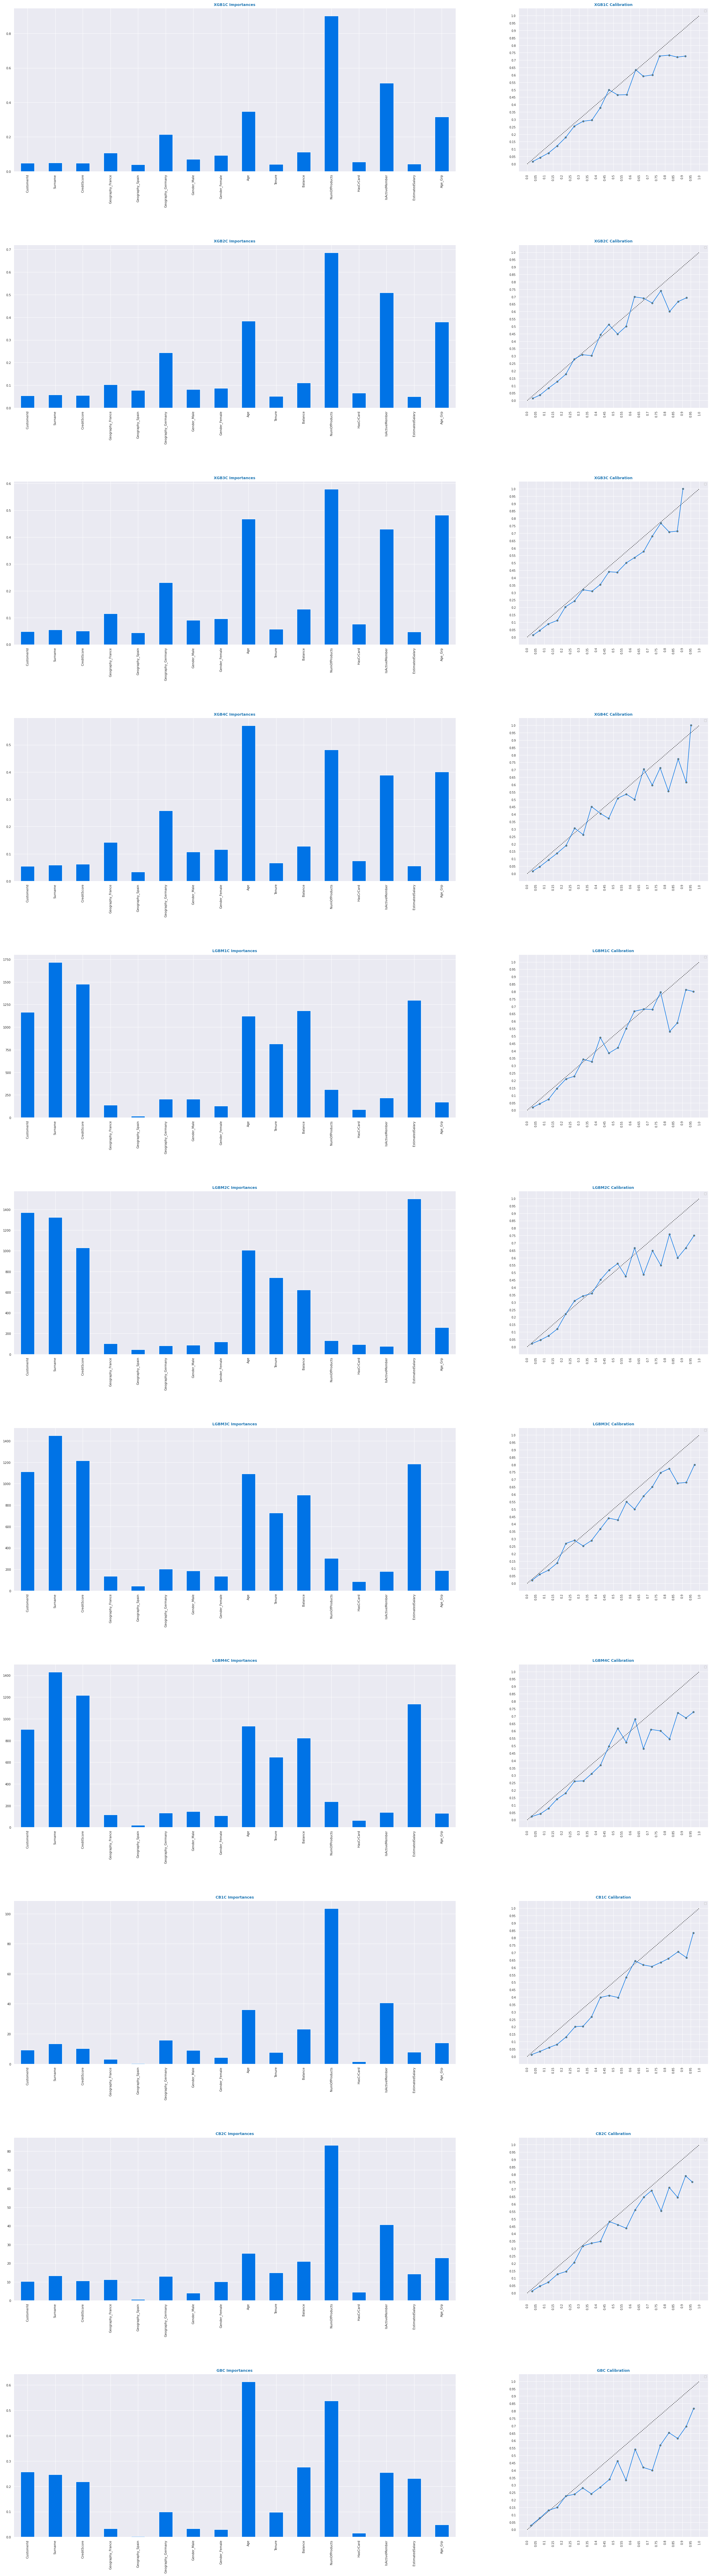

CPU times: user 8.78 s, sys: 276 ms, total: 9.05 s
Wall time: 8.84 s


In [26]:
%%time 

if CFG.ML == "Y":
    md.MakeMLPlots();
    
collect();
print();

In [25]:
%%time 

# Saving the datasets:-
if CFG.ML == "Y":
    Mdl_Preds.index.name = "id";
    sub_fl = pp.sub_fl.copy();
    sub_fl[CFG.target] = Mdl_Preds["Ensemble"].values;
    sub_fl.to_csv(f"Submission_V{CFG.version_nb}.csv", index = None);
    OOF_Preds.to_csv(f"OOF_Preds_V{CFG.version_nb}.csv");
    Mdl_Preds.to_csv(f"Mdl_Preds_V{CFG.version_nb}.csv");
    
    PrintColor(f"\nFinal submission file\n");
    display(sub_fl.head(10).style.format(precision = 3));
    
collect();
print(); 


Final submission file



,id,Exited
0,165034,0.942
1,165035,0.341
2,165036,0.946
3,165037,0.746
4,165038,0.703
5,165039,0.935
6,165040,0.865
7,165041,0.853
8,165042,0.397
9,165043,0.958



CPU times: user 1.64 s, sys: 32.4 ms, total: 1.67 s
Wall time: 1.67 s


<a id="8"></a>
# <div style= "font-family: Cambria; font-weight:bold; letter-spacing: 0px; color:#ffffff; font-size:120%; text-align:left;padding:3.0px; background: #0052cc; border-bottom: 8px solid #cc9966" > NEXT STEPS<br> <div> 

<div style= "font-family: Cambria; letter-spacing: 0px; color:#000000; font-size:110%; text-align:left;padding:3.0px; background: #f2f2f2" >
1. We will perform a detailed EDA and elicit feature interactions and other relevant insights<br>
2. Model tuning<br>
3. Including other models in the ensemble <br>
4. Better ensemble strategy <br>
5. Any other discussion/ public work based insights <br>
</div>